<a href="https://colab.research.google.com/github/Alejandro-ZZ/Machine-Learning-UNS/blob/master/3_1_KNN_Overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Vecinos más cercanos (Generalidades)**

Se generarán distintos clasificadores K-vecinos más cercanos (KNN) para evaluar su calidad a partir de la variación de parámetros como el porcentaje de datos para entrenamiento y prueba, la cantidad de vecinos cercanos (k), entre otros.

## **1. Funciones y librerias**

Primero se definen funciones útiles para el desarrollo del trabajo práctico.

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

from matplotlib.colors import ListedColormap

In [ ]:
def create_dataset(mu1:float, sigma1:float, mu2:float, sigma2:float, n_samples:int, n_features:int):
  '''
  Creates a dataset with two target values ['A', 'B'] and attribute values with 
  Gaussian distribution for specified values of mean (mu) and standard 
  deviation (sigma).

  Output
  ------
  out1: pandas.DataFrame
        Output dataset with `n_features + 1` columns. The last column name is 
        'Y' and has the two possible target values ['A', 'B'].

        The others columns has the feature values with a Gaussian distribution 
        and they are named as 'Xn' where `n` is the feature number.
  
  Inputs
  ------
  mu1: float
       Mean ("centre") of the distribution for the target 'A'.

  sigma1: float
          Standard deviation (spread or “width”) of the distribution 
          for the target 'A'. Must be non-negative.
  
  mu2: float
       Mean ("centre") of the distribution for the target 'B'.

  sigma2: float
          Standard deviation (spread or “width”) of the distribution 
          for the target 'B'. Must be non-negative.

  n_samples: int
             Total number of samples for each target value.

  n_features: int
              Total number of features.
  '''
  # Creates a seed for random creation
  np.random.seed(1)

  # Creates column name for each feature
  cols = ['X' + str(i+1) for i in range(2)]

  # Values for target 'A'
  target_A = pd.DataFrame(np.random.normal(loc = mu1, scale = sigma1, size = (n_samples,n_features)),
                          columns=cols)
  target_A['Y'] = 'A'

  # Values for target 'B'
  target_B = pd.DataFrame(np.random.normal(loc = mu2, scale = sigma2, size = (n_samples,n_features)),
                          columns=cols)
  target_B['Y'] = 'B'

  # Join both target values in one dataframe
  dataset = pd.concat([target_A, target_B])
  dataset = dataset.reset_index(drop=True)

  return dataset


def apply_knn_models(X, y, test_size, all_stats=False):
  '''
  Create, train, and evaluate the KNN model with different neighbor values.

  Outputs
  -------
  out1: int
        Maximum number of k-neighbors with which each KNN model is 
        trained with steps of one.

  out2: numpy.array
        Values of accuracy of each KNN model.

  out3: list
        List with all KNN models trainned.

  Optional
  --------
  out4: numpy.array
        Values of bias of each KNN model.

  out5: numpy.array
        Values of FDR of each KNN model.
  
  Inputs
  ------
  X: numpy.array
     Features for the models.
  
  y: numpy.array
     Target for the models.

  test_size: float
             Size for the test dataset. Values are in range (0.0, 1.0)
  '''
  X = X.to_numpy()
  y = y.to_numpy()

  # Splits the features and target in train and test data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=4)
  train_rows, train_columns = X_train.shape

  # Encodes target values from categorical to numerical
  le = LabelEncoder()
  y_train = le.fit_transform(y_train)
  y_test = le.fit_transform(y_test)

  # Selects a maximun k-neighbors of `n_train_samples/2 + 10` 
  # to test each KNN classifier
  Ks = int(train_rows / 2 + 10)

  # Initializes stats variables
  accuracy = np.zeros((Ks-1))
  models = []
  tn = np.zeros((Ks-1))
  fp = np.zeros((Ks-1))
  fn = np.zeros((Ks-1))
  tp = np.zeros((Ks-1))

  # Trains each KNN model for every value in `Ks`
  print(f'Entrenando los modelos para valores de k-vecinos en un rango de [1, {Ks-1}]\n')
  for k in range(1, Ks):
      
      # Trains and predicts model
      clf = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
      yhat = clf.predict(X_test)

      # Evaluation params of the model
      accuracy[k-1] = metrics.accuracy_score(y_test, yhat)
      models.append(clf)
      tn[k-1], fp[k-1], fn[k-1], tp[k-1] = confusion_matrix(y_test, yhat).ravel()

  bias = ((tp+fn)/(tn+fp))/((tp+fp)/(tn+fn))
  fdr = fp/(tp+fp)

  if all_stats:
    return Ks, accuracy, models, bias, fdr
  else:
    return Ks, accuracy, models



def regions_plot(X, y, knn_model, test_size, axis=None):
  
  # Converts DataFrame or Series to numpy array
  X = X.to_numpy()
  y = y.to_numpy()

  # Train and test dataset
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=4)

  # Encodes target values from categorical to numerical
  le = LabelEncoder()
  y_train = le.fit_transform(y_train)

  # Crea un mapa de colores
  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

  # Preparación para el gráfico 
  x_min, x_max = X_train[:, 0].min() - .1, X_train[:, 0].max() + .1
  y_min, y_max = X_train[:, 1].min() - .1, X_train[:, 1].max() + .1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                          np.linspace(y_min, y_max, 100))
  Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])

  Z = Z.reshape(xx.shape)

  if axis:
    axis.pcolormesh(xx, yy, Z, cmap=cmap_light)
    axis.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
    axis.set_xlabel('X')
    axis.set_ylabel('Y')
  else:
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

## **2. Datasets**

Se procede a crear dos datasets, cada uno con 2 features y un target con los siguientes valores posibles [A, B].

            Distribution for dataset #1


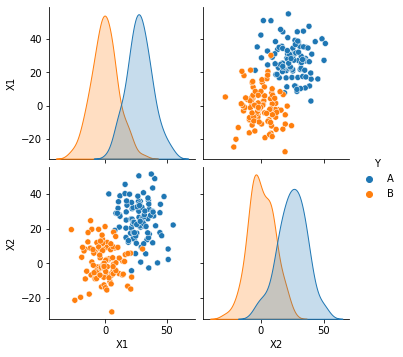

In [ ]:
dataset1 = create_dataset(mu1=25.0, sigma1=12.0, 
                          mu2=0.0, sigma2=10.0, 
                          n_samples=100, 
                          n_features=2)

print(' '*12 + 'Distribution for dataset #1')
sns.pairplot(data=dataset1, diag_kind="kde", hue='Y')
plt.show()

Para este segundo dataset, a comparación del primero, en este las features están más mezcladas (menor media y desviación estándar entre las etiquetas A y B).

            Distribution for dataset #2


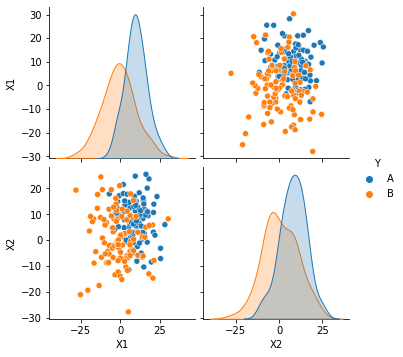

In [ ]:
dataset2 = create_dataset(mu1=8.0, sigma1=8.0, 
                          mu2=0.0, sigma2=10.0, 
                          n_samples=100, 
                          n_features=2)

print(' '*12 + 'Distribution for dataset #2')
sns.pairplot(data=dataset2, diag_kind="kde", hue='Y')
plt.show()

## **3. Clasificadores**

### **3.1. División de prueba: 50%**

Se analiza el comportamiento del modelo, para distintos K, tomando un 50% del dataset para entrenamiento y 50% para prueba.

Entrenando los modelos para valores de k-vecinos en un rango de [1, 59]

Entrenando los modelos para valores de k-vecinos en un rango de [1, 59]



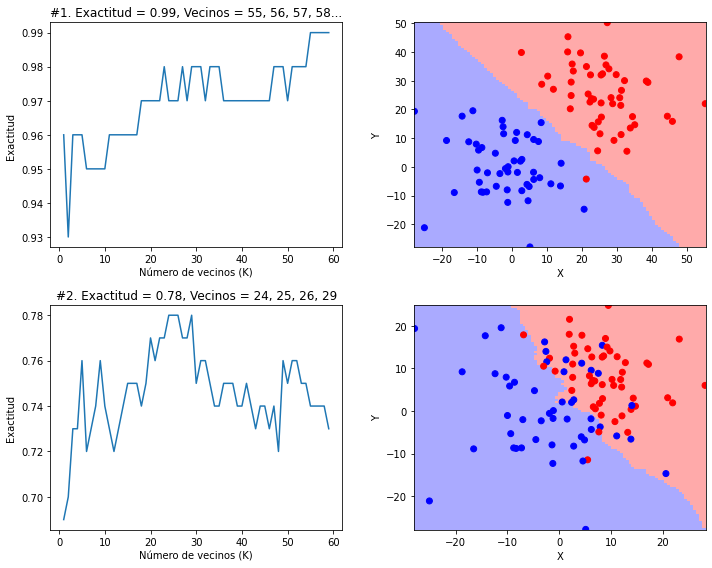

In [ ]:
# Gets all datasets
datasets = [dataset1, dataset2]

test_size = 0.5

# Grid of 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10,8))

index = 0
for dataset in datasets:

  # Get data to the model
  X = dataset[dataset.columns[:-1]]
  y = dataset[dataset.columns[-1]]

  # Output values for each KNN model
  Ks, accuracy, models = apply_knn_models(X, y, test_size=test_size)
  # Ks, accuracy, bias, fdr = apply_knn_models(X, y, test_size=0.5)

  # Indexes where max accuracy is found
  max_indexes = np.where(accuracy == accuracy.max())[0] + 1
  if len(max_indexes) > 4:
    max_indexes_str = ', '.join([str(index) for index in max_indexes[:4]]) + '...'
  else:
    max_indexes_str = ', '.join([str(index) for index in max_indexes])

  # Plot results
  axs[index, 0].plot(range(1,Ks), accuracy)
  axs[index, 0].set_title(f'#{index+1}. Exactitud = {accuracy.max()}, Vecinos = {max_indexes_str}')
  axs[index, 0].set_ylabel('Exactitud ')
  axs[index, 0].set_xlabel('Número de vecinos (K)')

  # First model whit MAX accuracy
  knn_model = models[max_indexes[0] - 1]

  # Plot regions
  regions_plot(X, y, knn_model=knn_model, test_size=test_size, axis=axs[index, 1])

  # Update indexes
  index += 1

plt.tight_layout()
plt.show()

Visto lo anterior se obtienen las siguientes anotaciones para un 50% de los datos para entrenamiento:

<br>

* Para el **dataset #1** se presenta una **exactitud del 99% para k = 55**. También se observa que a partir de este valor de k, la exactitud se mantiene igual.

* Para el **dataset #2**, se obtiene una **exactitud máxima del 78% para un k = 24**.

### **3.1. División de prueba: 20%**

Se analiza el comportamiento del modelo, para distintos K, tomando un 80% del dataset #1 para entrenamiento y 20% para prueba.

Entrenando los modelos para valores de k-vecinos en un rango de [1, 89]

Entrenando los modelos para valores de k-vecinos en un rango de [1, 89]



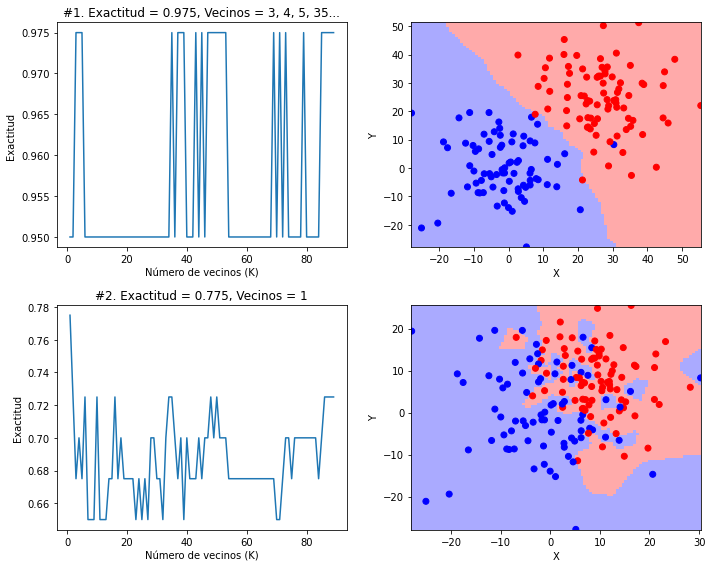

In [ ]:
# Gets all datasets
datasets = [dataset1, dataset2]

test_size = 0.2

# Grid of 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10,8))

index = 0
for dataset in datasets:

  # Get data to the model
  X = dataset[dataset.columns[:-1]]
  y = dataset[dataset.columns[-1]]

  # Output values for each KNN model
  Ks, accuracy, models = apply_knn_models(X, y, test_size=test_size)
  # Ks, accuracy, bias, fdr = apply_knn_models(X, y, test_size=0.5)

  # Indexes where max accuracy is found
  max_indexes = np.where(accuracy == accuracy.max())[0] + 1
  if len(max_indexes) > 4:
    max_indexes_str = ', '.join([str(index) for index in max_indexes[:4]]) + '...'
  else:
    max_indexes_str = ', '.join([str(index) for index in max_indexes])

  # Plot results
  axs[index, 0].plot(range(1,Ks), accuracy)
  axs[index, 0].set_title(f'#{index+1}. Exactitud = {accuracy.max()}, Vecinos = {max_indexes_str}')
  axs[index, 0].set_ylabel('Exactitud ')
  axs[index, 0].set_xlabel('Número de vecinos (K)')

  # First model whit MAX accuracy
  knn_model = models[max_indexes[0] - 1]

  # Plot regions
  regions_plot(X, y, knn_model=knn_model, test_size=test_size, axis=axs[index, 1])

  # Update indexes
  index += 1

plt.tight_layout()
plt.show()

Para esta proporción de datos para entrenamiento y prueba se obtiene:
<br><br>

* `dataset #1` los modelos arrojan **exactitudes entre 0.95 y 0.975**. Además, este último valor se presenta para varios valores de k, siendo el primero de ellos k = 3.

* `dataset #2` en este caso, se presenta una **exactitud del 0.775** para K = 1. 

* Recuérdese que para K muy pequeños esto genera un sobreajuste (overfitting). Esto se puede observar en la gráfica de regiones para el `dataset #2`. Por ello, se observan espacios/islas donde el modelo cambia la clasificación de forma repentina, haciéndolo inestable.
<br>

Dado la inestabilidad para el `dataset #2`, se analizan los demás puntajes de exactitud para ese dataset pero esta vez tambien se analiza el sesgo de cada modelo y la relación de falsos positivos clasificados (FDR).

Entrenando los modelos para valores de k-vecinos en un rango de [1, 89]



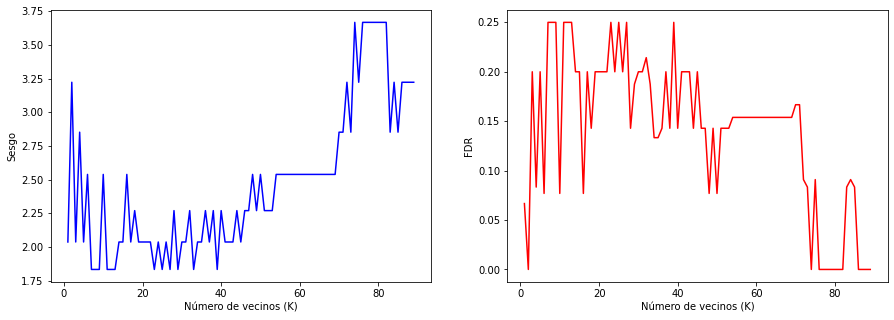

In [ ]:
# Get data to the model
X = dataset2[dataset2.columns[:-1]]
y = dataset2[dataset2.columns[-1]]

# Get all stats for dataset 2
Ks, accuracy, models, bias, fdr = apply_knn_models(X, y, test_size=test_size, all_stats=True)

# Display results
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(range(1,Ks), bias,'b')
axs[0].set_ylabel('Sesgo')
axs[0].set_xlabel('Número de vecinos (K)')

axs[1].plot(range(1,Ks), fdr,'r')
axs[1].set_ylabel('FDR')
axs[1].set_xlabel('Número de vecinos (K)')

plt.show()

In [ ]:
max_indexes = np.where(accuracy == accuracy[1:].max())[0]
print('Exactitud máxima luego de k = 1:', accuracy[1:].max(), '\n')

rows = []
for index in max_indexes:
  rows.append((index + 1, bias[index], fdr[index]))

data = pd.DataFrame(rows, columns=['Neighbors', 'Bias', 'FDR'])
data.sort_values(by='FDR', ascending=True, ignore_index=True)

Exactitud máxima luego de k = 1: 0.725 



,Neighbors,Bias,FDR
0,2,3.222222,0.000000
1,86,3.222222,0.000000
2,87,3.222222,0.000000
3,88,3.222222,0.000000
4,89,3.222222,0.000000
5,6,2.538462,0.076923
6,10,2.538462,0.076923
7,16,2.538462,0.076923
8,48,2.538462,0.076923
9,50,2.538462,0.076923


* Obsérvese que el siguiente valor de exactitud después de 0.775 es 0.725. Este segundo valor se presenta para varios valores de k. 

* Evaluando la menor tasa de FDR para un valor mínimo de sesgo, obtenemos `k = [86, 50, 34]`. 

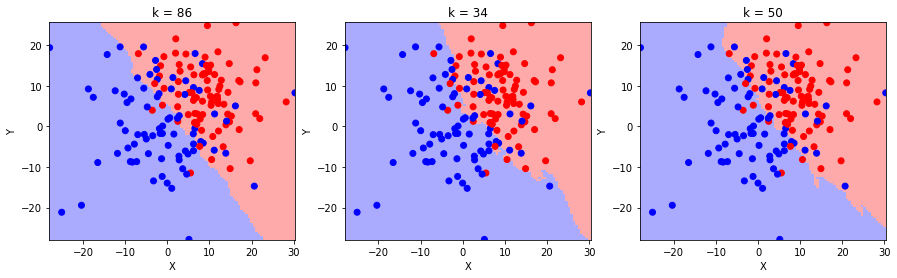

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))

# Plot regions
axs[0].set_title('k = 86')
regions_plot(X, y, knn_model=models[85], test_size=test_size, axis=axs[0])

axs[1].set_title('k = 34')
regions_plot(X, y, knn_model=models[33], test_size=test_size, axis=axs[1])

axs[2].set_title('k = 50')
regions_plot(X, y, knn_model=models[49], test_size=test_size, axis=axs[2])

plt.show()

Dependiendo de la aplicación del modelo, se puede basar la decisión para elegir basado en el bias o FDR.

# **Conclusión**

1. Como era de esperarse, entre más mezclados se encuentren los datos (media y DS más cercana entre los datos) menor es la calidad del clasificador de K vecinos más cercanos.

2. Se observa que para una división del 50% de datos tanto para entrenamiento como para prueba, se obtienen mejores resultados en los parámetros de calidad del modelo a comparación de tomar 80% para entrenamiento y 20% para prueba.

3. En algunas gráficas de la exactitud en función de los K vecinos, se observa en repetidas ocasiones la exactitud máxima del modelo. En estos comportamientos es fundamental tener en cuenta la varianza y sesgo del clasificador para los K específicos a evaluar. 

[Nearest-neighbor prediction on iris](https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_iris_knn.html)